In [ ]:
# Script to see how well your uncertainty scheme works for a given mechanism

In [22]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties
import rmgpy.exceptions

import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/moon/autoscience/reaction_calculator/database')
import database_fun

In [33]:
def get_node_std(rxns, family):
    if len(rxns) == 1:
        print('NO SIDT EST')
        return np.nan
#         return 1.329
    recipe = database.kinetics.families[family].forward_recipe

    rxns = np.array(rxns)

    label = ''
    Tref = 1000.0
    data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

    n = len(rxns)

    dlnks = np.array([
        np.log(
            rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
            .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
            .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
        ) for i, rxn in enumerate(rxns)
    ])


    varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
    # weighted average calculations
    ws = 1.0 / varis
    V1 = ws.sum()
    V2 = (ws ** 2).sum()
    mu = np.dot(ws, dlnks) / V1
    s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

    kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)

    std_dev = kin_uncertainty.get_expected_log_uncertainty() / .398

    return std_dev

In [2]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [3]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'primaryNS',
    'NitrogenCurran',
    'NOx2018',
    'FFCM1(-)',
    'SulfurLibrary',
    'SulfurGlarborgH2S',
    'SABIC_aromatics',
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
    kinetics_families = 'all',
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False, # Don't bother loading the depository information, as we don't use it
)

In [28]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
for family_name in database.kinetics.families.keys():
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)


ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.419,128.588,135.2,140.503,147.924,152.211,155.919],'J/(mol*K)'), H298=(19.7155,'kJ/mol'), S298=(387.478,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)2) + group(CsCsClClH) + radical(CsCl1sCl1sCs)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.592,151.36,159.399,165.718,174.181,178.534,180.476],'J/(mol*K)'), H298=(-162.929,'kJ/mol'), S298=(391.397,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3) + group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3)""").
The thermo for this species is probabl

In [4]:
# load aramco
aramco_chemkin_file = '/home/moon/autoscience/aramco/chem_annotated.inp'
aramco_dict_file = '/home/moon/autoscience/aramco/species_dictionary.txt'

species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(aramco_chemkin_file, aramco_dict_file)


In [5]:
display(reaction_listA[280])

NO SIDT EST


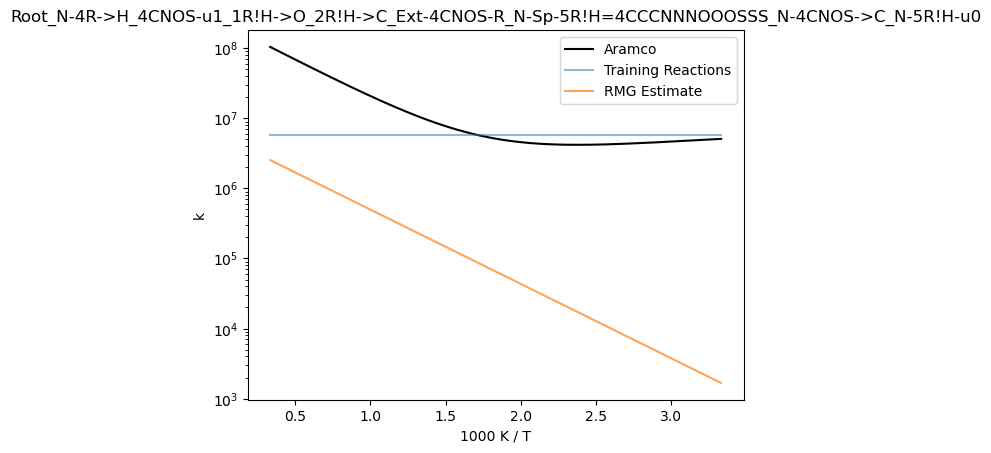

NO SIDT EST


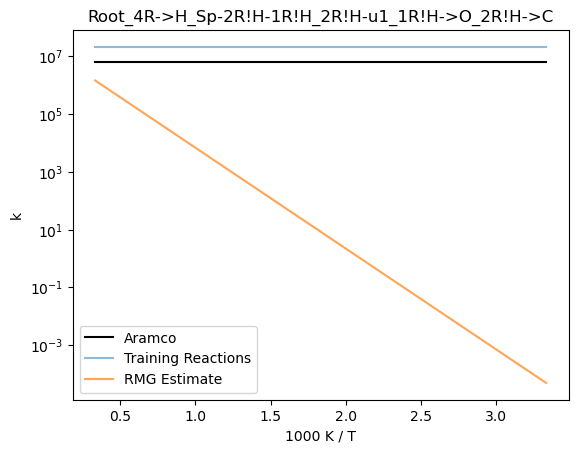

NO SIDT EST


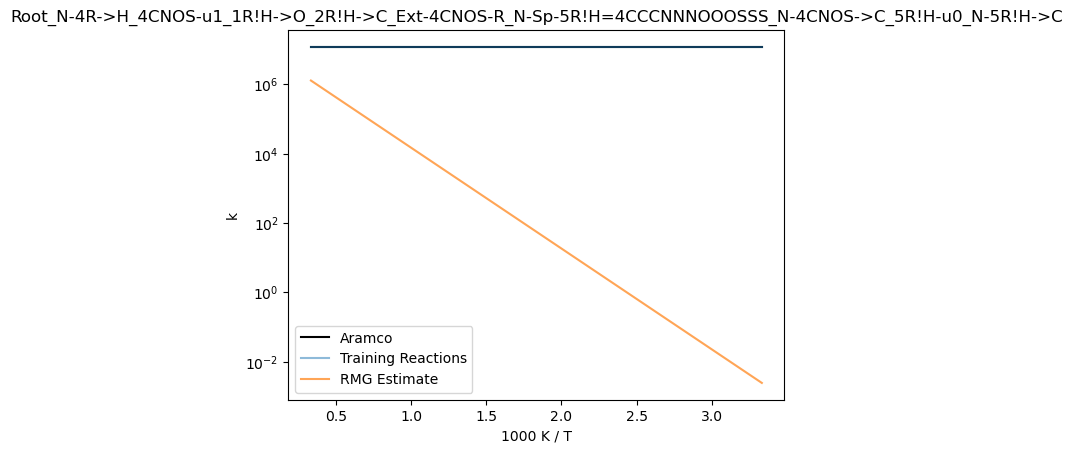

NO SIDT EST


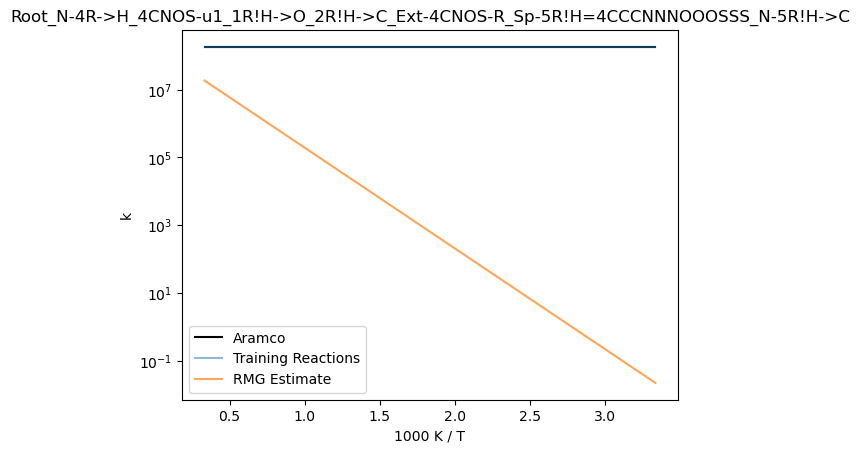

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


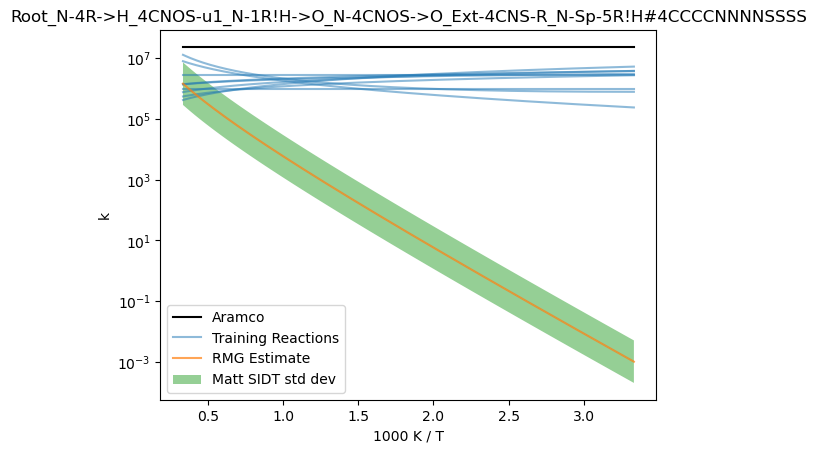

In [64]:
i = 280
# i = 124
for i in disps[0:5]:
    my_rxn = copy.deepcopy(reaction_listA[i])


    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    Tref = 1000.0
    T = np.linspace(300, 3000, 1001)
    P = 101325
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = my_rxn.get_rate_coefficient(T[j], P)
    plt.plot(1000.0 / T, k, label=f'Aramco', color='black')

    fam_rxn_list = database.kinetics.generate_reactions_from_families(
        reactants=my_rxn.reactants,
        products=my_rxn.products,
        only_families=None,
        resonance=True,
    )

    for family in [r.family for r in fam_rxn_list]:
        database.kinetics.families[family].add_atom_labels_for_reaction(my_rxn)

        template_labels = database.kinetics.families[family].get_reaction_template_labels(my_rxn)
        template = database.kinetics.families[family].retrieve_template(template_labels)

        kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]



    # also plot Matt's uncertainty, which means we need the families/nodes
    node = template[0].label
    rxns = auto_gen_families[f'{family}_rxn_map'][node]
    for z in range(len(rxns)):
        rxn = rxns[z]
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
            k[j] = rxn.get_rate_coefficient(T[j])
        if z == 0:
            plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
        else:
            plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
        plt.yscale('log')

    k = np.zeros(len(T))
    for j in range(0, len(T)):
        k[j] = kinetics.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'RMG Estimate', color=colors[1], alpha=0.7)


    if len(rxns) == 1:
        print('NO SIDT EST')
    else:
        r = rmgpy.reaction.Reaction()
        r.kinetics = kinetics

        sigma_lnk = get_node_std(rxns, family)

    #     sigma_lnk = database.kinetics.families[family].extract_source_from_comments(r)[1][1]['node_std_dev']
        sigma_k = np.exp(sigma_lnk)
        plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
        plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[2], edgecolor=None)    

    plt.title(node)
    plt.xlabel ('1000 K / T')
    plt.ylabel('k')
    plt.yscale('log')
    plt.legend()
    plt.show()
    # gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
    # gao_sigma_k = np.exp(gao_sigma_lnk)


    # # Plot node std dev
    # plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
    # plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)





In [50]:
len(rxns)

1

In [59]:
database.kinetics.families[family].extract_source_from_comments(r)[1][1]

{'template': '',
 'degeneracy': 1,
 'exact': False,
 'rules': '',
 'training': '',
 'node': 'Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O'}

In [47]:
r = rmgpy.reaction.Reaction()
r.kinetics = kinetics

In [48]:
database.kinetics.families[family].extract_source_from_comments(r)

(False,
 ['Disproportionation',
  {'template': '',
   'degeneracy': 1,
   'exact': False,
   'rules': '',
   'training': '',
   'node': 'Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0'}])

In [46]:
kinetics

ArrheniusBM(A=(5.7209e+06,'m^3/(mol*s)'), n=0, w0=(679500,'J/mol'), E0=(20296,'J/mol'), Tmin=(298,'K'), uncertainty=RateUncertainty(mu=0.0, var=33.13686319048999, Tref=1000.0, N=1, data_mean=0.0, correlation='Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0',), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0""")

In [41]:
dir(database.kinetics.families[family].rules.entries[node][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'binding_energies',
 'children',
 'data',
 'data_count',
 'facet',
 'get_all_descendants',
 'index',
 'item',
 'label',
 'long_desc',
 'metal',
 'nodal_distance',
 'parent',
 'rank',
 'reference',
 'reference_type',
 'short_desc',
 'site',
 'surface_site_density']

In [40]:
database.kinetics.families[family].rules.entries[node][0].data

ArrheniusBM(A=(5.7209e+06,'m^3/(mol*s)'), n=0, w0=(679500,'J/mol'), E0=(20296,'J/mol'), Tmin=(298,'K'), uncertainty=RateUncertainty(mu=0.0, var=33.13686319048999, Tref=1000.0, N=1, data_mean=0.0, correlation='Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0',), comment="""BM rule fitted to 1 training reactions at node Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0
    Total Standard Deviation in ln(k): 11.540182761524994""")

In [30]:
template[0].label

'Root_N-4R->H_4CNOS-u1_1R!H->O_2R!H->C_Ext-4CNOS-R_N-Sp-5R!H=4CCCNNNOOOSSS_N-4CNOS->C_N-5R!H-u0'

In [19]:
fam_rxn_list[0].kinetics

In [63]:
disps = []
# for i in range(400):
for i in range(len(reaction_listA)):
    # see if the reaction matches an RMG family...
    my_rxn = copy.deepcopy(reaction_listA[i])
    try:
        database.kinetics.families['Disproportionation'].add_atom_labels_for_reaction(my_rxn)
    except rmgpy.exceptions.ActionError:
#         print(f'Reaction {i} is not a Disp reaction')
        continue
    
    disps.append(i)
    print(f'Reaction {i} is a Disp reaction')
    

Reaction 124 is a Disp reaction
Reaction 125 is a Disp reaction
Reaction 126 is a Disp reaction
Reaction 127 is a Disp reaction
Reaction 129 is a Disp reaction
Reaction 130 is a Disp reaction
Reaction 131 is a Disp reaction
Reaction 132 is a Disp reaction
Reaction 134 is a Disp reaction
Reaction 135 is a Disp reaction
Reaction 136 is a Disp reaction
Reaction 137 is a Disp reaction
Reaction 138 is a Disp reaction
Reaction 144 is a Disp reaction
Reaction 203 is a Disp reaction
Reaction 205 is a Disp reaction
Reaction 211 is a Disp reaction
Reaction 263 is a Disp reaction
Reaction 276 is a Disp reaction
Reaction 278 is a Disp reaction
Reaction 279 is a Disp reaction
Reaction 280 is a Disp reaction
Reaction 322 is a Disp reaction
Reaction 323 is a Disp reaction
Reaction 324 is a Disp reaction
Reaction 346 is a Disp reaction
Reaction 401 is a Disp reaction
Reaction 403 is a Disp reaction
Reaction 404 is a Disp reaction
Reaction 422 is a Disp reaction
Reaction 444 is a Disp reaction
Reaction

In [ ]:
reaction_listA[0]

In [ ]:
database.kinetics.families['Disproportionation'].add_atom_labels_for_reaction(reaction_listA[0])

In [ ]:
z = 80
print(reaction_list[z].family)
display(reaction_list[z])
print(reaction_list[z].kinetics)

my_rxn = copy.deepcopy(reaction_list[z])

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

database.kinetics.families[reaction_list[z].family].add_atom_labels_for_reaction(my_rxn)

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

template_labels = database.kinetics.families[my_rxn.family].get_reaction_template_labels(my_rxn)
print(template_labels)
template = database.kinetics.families[my_rxn.family].retrieve_template(template_labels)
print(template)
print()

kinetics = database.kinetics.families[my_rxn.family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
print(kinetics)

plot_kinetics([reaction_list[z], my_rxn], labels=['Original', 'refitted'])